<center>
    <h1>Toxic Comment Classification</h1>
    <h5>Detect toxic content to improve online conversations</h5>
    <h5>Dataset - Quora Insincere Questions Classification</h5>

</center>

<h3> Brief Problem Statement </h3>
<h5>
    An existential issue for any major website nowadays is how to handle toxic and divisive content.
    A key challenge is to get rid of toxic/insincere comments/text -- those founded upon false premises, or that intend to make a statement rather than look for helpful answers.
</h5>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
train = pd.read_csv('../input/quora-insincere-questions-classification/train.csv')
test = pd.read_csv('../input/quora-insincere-questions-classification/test.csv')

In [ ]:
train.shape, test.shape

In [ ]:
train.head()

In [ ]:
test.head()

Check for missing values

In [ ]:
train.isnull().sum()

In [ ]:
test.isnull().sum()

In [ ]:
train['target'].value_counts()

In [ ]:
train['target'].value_counts().plot.bar()

By analyzing above data, we can say that **Data is Imbalanced** 

In [ ]:
toxic = train[train['target'] == 1]
non_toxic = train[train['target'] == 0]

In [ ]:
non_toxic.head()

In [ ]:
toxic.head()

Building n-grams for analyzing data

In [ ]:
import nltk
from nltk.util import ngrams
from nltk.corpus import stopwords
import re

REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def pre_process(text):
    text = text.lower()
    text = REPLACE_BY_SPACE_RE.sub(' ', text)
    text = BAD_SYMBOLS_RE.sub('', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS)
    return text

def build_ngrams(text, ngram):
    text = text.lower()
    text = REPLACE_BY_SPACE_RE.sub(' ', text)
    text = BAD_SYMBOLS_RE.sub('', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) 
    tokenize = nltk.word_tokenize(text)
    return list(ngrams(tokenize, ngram))

In [ ]:
train['question_text'] = train['question_text'].apply(lambda x: pre_process(x))
test['question_text'] = test['question_text'].apply(lambda x: pre_process(x))

In [ ]:
print(build_ngrams('I am testing ngrams', 1))
print(build_ngrams('I am testing ngrams', 2))
print(build_ngrams('I am testing ngrams', 3))

In [ ]:
def plot_horizontal_bar(data, title):
    plt.figure(figsize=(20, 20))
    freq = pd.DataFrame(sorted(data.items(), key=lambda x: x[1]), columns=['Word','Count'])
    sns.barplot(x='Count', y='Word', data=freq.sort_values(by="Count", ascending=True).tail(30))
    plt.title(title)
    plt.tight_layout()
    plt.show()

Creating One-grams, Bigrams, Trigrams

In [ ]:
%%time
from collections import defaultdict

onegram_nontoxic_freq = defaultdict(int)
for sentence in non_toxic['question_text']:
    for word in build_ngrams(sentence, 1):
        onegram_nontoxic_freq[word] += 1
        

onegram_toxic_freq = defaultdict(int)
for sentence in toxic['question_text']:
    for word in build_ngrams(sentence, 1):
        onegram_toxic_freq[word] += 1
        
        
bigram_nontoxic_freq = defaultdict(int)
for sentence in non_toxic['question_text']:
    for word in build_ngrams(sentence, 2):
        bigram_nontoxic_freq[word] += 1
        

bigram_toxic_freq = defaultdict(int)
for sentence in toxic['question_text']:
    for word in build_ngrams(sentence, 2):
        bigram_toxic_freq[word] += 1
        
        

trigram_nontoxic_freq = defaultdict(int)
for sentence in non_toxic['question_text']:
    for word in build_ngrams(sentence, 3):
        trigram_nontoxic_freq[word] += 1
        

trigram_toxic_freq = defaultdict(int)
for sentence in toxic['question_text']:
    for word in build_ngrams(sentence, 3):
        trigram_toxic_freq[word] += 1

Plotting Top Frequency N-grams

In [ ]:
plot_horizontal_bar(onegram_toxic_freq, 'Top Toxic Words')

In [ ]:
plot_horizontal_bar(onegram_nontoxic_freq, 'Top Non-Toxic Words')

In [ ]:
plot_horizontal_bar(bigram_toxic_freq, 'Top Toxic Bigrams')

In [ ]:
plot_horizontal_bar(bigram_nontoxic_freq, 'Top Non-Toxic Bigrams')

In [ ]:
plot_horizontal_bar(trigram_toxic_freq, 'Top Toxic Trigrams')

In [ ]:
plot_horizontal_bar(trigram_nontoxic_freq, 'Top Non-Toxic Trigrams')

In [ ]:
train['target'].value_counts()

In [ ]:
plt.pie(train['target'].value_counts().to_list(), labels=['Non Toxic', 'Toxic'], autopct='%1.1f%%')

After analyzing above, we can say that data is highly imbalanced. Imbalanced data is a scenario where the number of observations belonging to one class is significantly lower than those belonging to the other classes. Machine Learning algorithms tend to produce unsatisfactory classifiers when faced with imbalanced datasets.
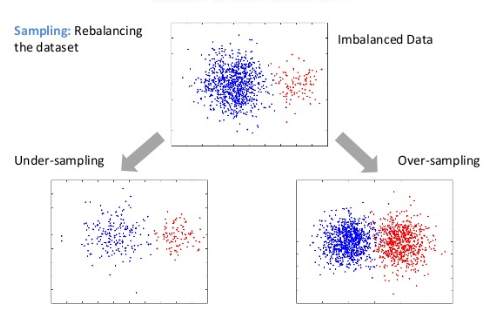

In [ ]:
from sklearn.utils import resample
non_toxic = resample(non_toxic, replace=False, n_samples=1000001, random_state=25)
toxic = resample(toxic, replace=True, n_samples=120001, random_state=25)
train = pd.concat([non_toxic, toxic])

In [ ]:
plt.pie(train['target'].value_counts().to_list(), labels=['Non Toxic', 'Toxic'], autopct='%1.1f%%')

In [ ]:
train["num_chars"] = train["question_text"].apply(lambda x: len(str(x)))
test["num_chars"] = test["question_text"].apply(lambda x: len(str(x)))

train["num_words"] = train["question_text"].apply(lambda x: len(str(x).split()))
test["num_words"] = test["question_text"].apply(lambda x: len(str(x).split()))

train["num_unique_words"] = train["question_text"].apply(lambda x: len(set(str(x).split())))
test["num_unique_words"] = test["question_text"].apply(lambda x: len(set(str(x).split())))

In [ ]:
axes= sns.boxplot(x='target', y='num_words', data=train)
axes.set_xlabel('Target')
axes.set_title("Number of words in each class")
plt.show()

In [ ]:
axes= sns.boxplot(x='target', y='num_chars', data=train)
axes.set_xlabel('Target')
axes.set_title("Number of num_chars in each class")
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
train, validation = train_test_split(train, test_size=0.15, random_state=25)

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

embed_size = 300
max_features = 50000
maxlen = 100

tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(train['question_text']))

train_X = tokenizer.texts_to_sequences(train['question_text'])
test_X = tokenizer.texts_to_sequences(test['question_text'])
validation_X = tokenizer.texts_to_sequences(validation['question_text'])

train_X = pad_sequences(train_X, maxlen=maxlen)
test_X = pad_sequences(test_X, maxlen=maxlen)
validation_X = pad_sequences(validation_X, maxlen=maxlen)


word_index = tokenizer.word_index
unq_len = min(max_features, len(word_index))

In [ ]:
import pickle
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
def loadGlove(file_path):
    f = open(file_path, 'r')
    glove_embeddings_index = {}
    
    for line in f:
        lines = line.split(' ')
        word, coef = lines[0], np.asarray(lines[1: ], dtype='float32')
        glove_embeddings_index[word] = coef
        
    all_embs = np.stack(glove_embeddings_index.values())
    emb_mean,emb_std = all_embs.mean(), all_embs.std()
    embed_size = all_embs.shape[1]
        
    embedding_matrix = np.random.normal(emb_mean, emb_std, (min(max_features, len(word_index)), embed_size))

    for word, i in word_index.items():
        if i < max_features: 
            embedding_vector = glove_embeddings_index.get(word)
            if embedding_vector is not None: 
                embedding_matrix[i] = embedding_vector
    
    return embedding_matrix

In [ ]:
import io
from tqdm import tqdm

def loadWiki(file_path):
    
    fin = open(file_path, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())
    data = {}
    cnt = 0
    for line in tqdm(fin):
#         if(cnt == 500000):
#             break
        tokens = line.rstrip().split(' ')
        data[tokens[0]] =  np.asarray(tokens[1: ], dtype='float32')
        cnt += 1
        
#     def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
#     data = dict(get_coefs(*o.split(" ")) for o in open('../input/quora-insincere-questions-classification/embeddings/wiki-news-300d-1M/wiki-news-300d-1M.vec') if len(o)>100)

        
    all_embs = np.stack(data.values())
    emb_mean,emb_std = all_embs.mean(), all_embs.std()
    embed_size = all_embs.shape[1]
        
    embedding_matrix = np.random.normal(emb_mean, emb_std, (min(max_features, len(word_index)), embed_size))

    for word, i in word_index.items():
        if i < max_features: 
            embedding_vector = data.get(word)
            if embedding_vector is not None: 
                embedding_matrix[i] = embedding_vector
    
    return embedding_matrix


# %%time


In [ ]:
%%time
embedding_matrix = loadGlove('../input/glove840b300dtxt/glove.840B.300d.txt')

In [ ]:
!ls ../input/fasttext-wikinews/wiki-news-300d-1M.vec

In [ ]:
from keras.layers import Input, LSTM, Embedding, Dropout, Activation, CuDNNGRU, CuDNNLSTM, Dense, Bidirectional, GlobalMaxPool1D
from keras.models import Model

input_12 = Input(shape=(maxlen,))
layer = Embedding(max_features, embed_size, weights=[embedding_matrix])(input_12)
layer = Bidirectional(CuDNNLSTM(64, return_sequences=True))(layer)
layer = Bidirectional(CuDNNLSTM(64))(layer)
layer = Dense(1, activation="sigmoid")(layer)
model = Model(inputs = input_12, output = layer)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
y = train['target']
validation_y = validation['target']

In [ ]:
%%time
model.fit(train_X, y, epochs = 1, validation_data=(validation_X, validation_y))

In [ ]:
%%time
predict = model.predict(test_X)
predict_val = model.predict(validation_X)

In [ ]:
predict_bool = (np.array(predict) > 0.5).astype(np.int)

predict_val_bool = (np.array(predict_val) > 0.4).astype(np.int)

In [ ]:
from sklearn import metrics
metrics.accuracy_score(validation_y, predict_val_bool)

In [ ]:
metrics.f1_score(validation_y, predict_val_bool)

In [ ]:
print(metrics.classification_report(validation_y, predict_val_bool))

In [ ]:
submit = pd.DataFrame({'qid': test['qid'].values, 'prediction': predict_bool.flatten()})
submit.to_csv("submission.csv", index=False)

In [ ]:
model.save('saved.h5')
# json_string = model.to_json()
# print(json_string)

In [ ]:
model.save_weights('weights.h5')

In [ ]:
# import pickle
with open('model.pickle', 'wb') as handle:
    pickle.dump(model, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
embedding_matrix_wiki

In [ ]:
# del embedding_matrix_
import gc
gc.collect()

In [ ]:
%%time
# embedding_matrix_wiki = loadWiki('../input/embeddings-glove-crawl-torch-cached/wiki-news-300d-1M.vec')
embedding_matrix_wiki = loadWiki('../input/fasttext-wikinews/wiki-news-300d-1M.vec')

In [ ]:
%%time

input_12_w = Input(shape=(100,))
layer_w = Embedding(max_features, embed_size, weights=[embedding_matrix_wiki])(input_12_w)
layer_w = Bidirectional(CuDNNLSTM(64, return_sequences=True))(layer_w)
layer_w = Bidirectional(CuDNNLSTM(64))(layer_w)
layer_w = Dense(1, activation="sigmoid")(layer_w)
model_w = Model(inputs = input_12_w, output = layer_w)
model_w.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


model_w.fit(train_X, y, epochs = 1, validation_data=(validation_X, validation_y))

predict_val_w = model_w.predict(validation_X)
predict_val_bool_w = (np.array(predict_val_w) > 0.4).astype(np.int)

In [ ]:
print(metrics.classification_report(validation_y, predict_val_bool_w))